# Data Contamination Detection: Report Figures

This notebook generates publication-quality PDF figures comparing:
1. **TRACE** (our method) - Uses gradient norms, losses, and embedding trajectories
2. **Min-K% Probability** (baseline) - Uses token-level log probabilities


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Configure matplotlib for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded as TrueType
plt.rcParams['ps.fonttype'] = 42

In [2]:
# Configuration
SENSITIVITY_DIR = Path("../embeddings_sensitivity_3")
MIN_K_DIR = Path("../output-min-k")
DATA_DIR = Path("../data")
OUTPUT_DIR = Path("../report_figs")
MODEL_NAME = "mistralai--Mistral-7B-Instruct-v0.1"
DATASETS = ["math", "arc", "mmlu"]

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR.absolute()}")

# Color scheme
DATASET_COLORS = {
    'math': '#D62828',    # Rich red
    'arc': '#003049',     # Deep blue
    'mmlu': '#F77F00'     # Vibrant orange
}

METHOD_LINESTYLES = {
    'trace': '-',
    'min_k': '--'
}

Output directory: /afs/cs.wisc.edu/u/p/a/papageorgiou/re-bench-data-contamination/notebooks/../report_figs


## 1. Load TRACE Data

In [3]:
def load_trajectory_data(dataset_name, split="train"):
    """Load embedding trajectories and labels for TRACE."""
    base_path = SENSITIVITY_DIR / MODEL_NAME / dataset_name / "trajectory" / "probe" / split
    parquet_path = DATA_DIR / dataset_name / "probe" / f"{split}.parquet"
    
    required_files = [
        base_path / "embeddings.npy",
        base_path / "id_nums.npy",
        base_path / "losses.npy",
        base_path / "grad_norms.npy"
    ]
    
    if not all(p.exists() for p in required_files):
        print(f"Warning: Missing files for {dataset_name} ({split})")
        return None
        
    embeddings = np.load(base_path / "embeddings.npy")
    id_nums = np.load(base_path / "id_nums.npy")
    losses = np.load(base_path / "losses.npy")
    grad_norms = np.load(base_path / "grad_norms.npy")
    
    df = pd.read_parquet(parquet_path)
    id_to_label = dict(zip(df['id_num'], df['seen']))
    labels = np.array([id_to_label.get(id_num, False) for id_num in id_nums])
    
    return {
        "embeddings": embeddings,
        "losses": losses,
        "grad_norms": grad_norms,
        "labels": labels,
        "id_nums": id_nums
    }


def compute_embedding_features(data):
    """Compute L2 distance and angle between each step embedding and initial embedding."""
    embeddings = data['embeddings']
    E0 = embeddings[:, 0, :]
    n_samples, n_steps_plus_1, dim = embeddings.shape
    
    l2_distances = []
    angles = []
    
    norm_E0 = np.linalg.norm(E0, axis=1, keepdims=True) + 1e-8
    
    for i in range(1, n_steps_plus_1):
        Ei = embeddings[:, i, :]
        
        diff = Ei - E0
        dist = np.linalg.norm(diff, axis=1)
        l2_distances.append(dist)
        
        norm_Ei = np.linalg.norm(Ei, axis=1, keepdims=True) + 1e-8
        dot_product = (Ei * E0).sum(axis=1, keepdims=True)
        cosine_sim = dot_product / (norm_Ei * norm_E0)
        cosine_sim = np.clip(cosine_sim, -1.0, 1.0)
        angle = np.arccos(cosine_sim).squeeze()
        angles.append(angle)
    
    l2_distances = np.stack(l2_distances, axis=1)
    angles = np.stack(angles, axis=1)
    
    return l2_distances, angles


def prepare_features(data):
    """Prepare feature matrix for classification."""
    losses = data['losses']
    grad_norms = data['grad_norms']
    l2_distances, angles = compute_embedding_features(data)
    
    n_steps = losses.shape[1]
    feature_names = []
    features = []
    
    features.append(losses)
    for i in range(n_steps):
        feature_names.append(f"Loss_Step{i+1}")
    
    features.append(grad_norms)
    for i in range(n_steps):
        feature_names.append(f"GradNorm_Step{i+1}")
    
    features.append(l2_distances)
    for i in range(n_steps):
        feature_names.append(f"L2Dist_Step{i+1}")
    
    features.append(angles)
    for i in range(n_steps):
        feature_names.append(f"Angle_Step{i+1}")
    
    X = np.hstack(features)
    y = data['labels']
    
    return X, y, feature_names

## 2. Load Min-K% Data

In [4]:
def load_min_k_data(dataset_name):
    """Load Min-K% results for a dataset."""
    eval_path = MIN_K_DIR / MODEL_NAME / "final_model" / dataset_name / "eval.parquet"
    metrics_path = MIN_K_DIR / MODEL_NAME / "final_model" / dataset_name / "metrics.json"
    
    if not eval_path.exists():
        print(f"Warning: Min-K% data not found for {dataset_name}")
        return None, None
    
    df = pd.read_parquet(eval_path)
    
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    
    return df, metrics

## 3. Train TRACE Classifiers

In [5]:
print("="*80)
print("TRAINING TRACE CLASSIFIERS")
print("="*80)

trace_results = {}
trained_classifiers = {}  # Store classifiers and feature names for feature importance

for dataset in DATASETS:
    print(f"\nTraining {dataset.upper()}...")
    
    train_data = load_trajectory_data(dataset, split="train")
    eval_data = load_trajectory_data(dataset, split="eval")
    
    if train_data is None or eval_data is None:
        print(f"Skipping {dataset}")
        continue
    
    X_train, y_train, feature_names = prepare_features(train_data)
    X_test, y_test, _ = prepare_features(eval_data)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    clf = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
    y_pred = clf.predict(X_test_scaled)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = (y_pred == y_test).mean()
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    print(f"  AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
    
    trace_results[dataset] = {
        'auc': auc,
        'accuracy': accuracy,
        'fpr': fpr,
        'tpr': tpr,
        'y_test': y_test,
        'y_pred_proba': y_pred_proba
    }
    
    # Store classifier and feature names for feature importance analysis
    trained_classifiers[dataset] = {
        'clf': clf,
        'feature_names': feature_names,
        'scaler': scaler
    }

print(f"\n{'='*80}")
print("Training complete!")
print(f"{'='*80}")

TRAINING TRACE CLASSIFIERS

Training MATH...
  AUC: 0.6758, Accuracy: 0.6300

Training ARC...
  AUC: 0.7680, Accuracy: 0.7020

Training MMLU...
  AUC: 0.7995, Accuracy: 0.7240

Training complete!


## 4. Compute ROC Curves for Min-K%

In [6]:
print("="*80)
print("LOADING MIN-K% RESULTS")
print("="*80)

min_k_results = {}
best_k_ratio = 'min_k_30'  # Use 30% as the representative k ratio

for dataset in DATASETS:
    print(f"\nLoading {dataset.upper()}...")
    
    df, metrics = load_min_k_data(dataset)
    
    if df is None:
        print(f"Skipping {dataset}")
        continue
    
    # Get the min_k column (lower = seen, so negate for ROC)
    if best_k_ratio in df.columns:
        values = df[best_k_ratio].values
        labels = df['seen'].values.astype(bool)
        
        # Negate because lower min_k = more likely seen
        fpr, tpr, _ = roc_curve(labels, -values)
        auc = roc_auc_score(labels, -values)
        accuracy = metrics[best_k_ratio]['eval_accuracy']
        
        print(f"  AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")
        
        min_k_results[dataset] = {
            'auc': auc,
            'accuracy': accuracy,
            'fpr': fpr,
            'tpr': tpr,
            'metrics': metrics
        }

print(f"\n{'='*80}")
print("Loading complete!")
print(f"{'='*80}")

LOADING MIN-K% RESULTS

Loading MATH...
  AUC: 0.5858, Accuracy: 0.5760

Loading ARC...
  AUC: 0.6516, Accuracy: 0.6100

Loading MMLU...
  AUC: 0.6169, Accuracy: 0.5980

Loading complete!


## 5. Plot Combined ROC Curves

Saved: ../report_figs/roc_comparison.pdf


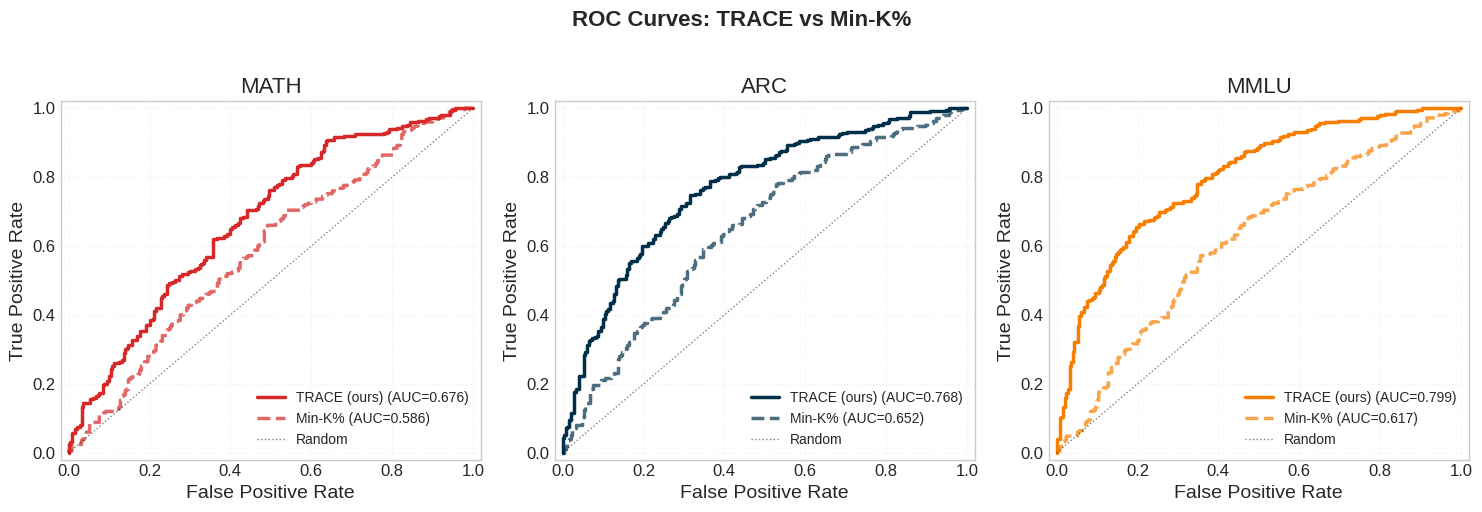

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, dataset in enumerate(DATASETS):
    ax = axes[idx]
    
    # Plot TRACE ROC
    if dataset in trace_results:
        tr = trace_results[dataset]
        ax.plot(tr['fpr'], tr['tpr'], 
                linestyle='-', linewidth=2.5, 
                color=DATASET_COLORS[dataset],
                label=f'TRACE (ours) (AUC={tr["auc"]:.3f})')
    
    # Plot Min-K% ROC
    if dataset in min_k_results:
        mink = min_k_results[dataset]
        ax.plot(mink['fpr'], mink['tpr'], 
                linestyle='--', linewidth=2.5, 
                color=DATASET_COLORS[dataset],
                alpha=0.7,
                label=f'Min-K% (AUC={mink["auc"]:.3f})')
    
    # Random baseline
    ax.plot([0, 1], [0, 1], 'k:', linewidth=1, alpha=0.5, label='Random')
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{dataset.upper()}')
    ax.legend(fontsize=10, loc='lower right')
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.grid(True, alpha=0.3, linestyle=':')

plt.suptitle('ROC Curves: TRACE vs Min-K%', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = OUTPUT_DIR / "roc_comparison.pdf"
plt.savefig(save_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.show()

## 6. Combined ROC Plot (All Datasets)

Saved: ../report_figs/roc_comparison_combined.pdf


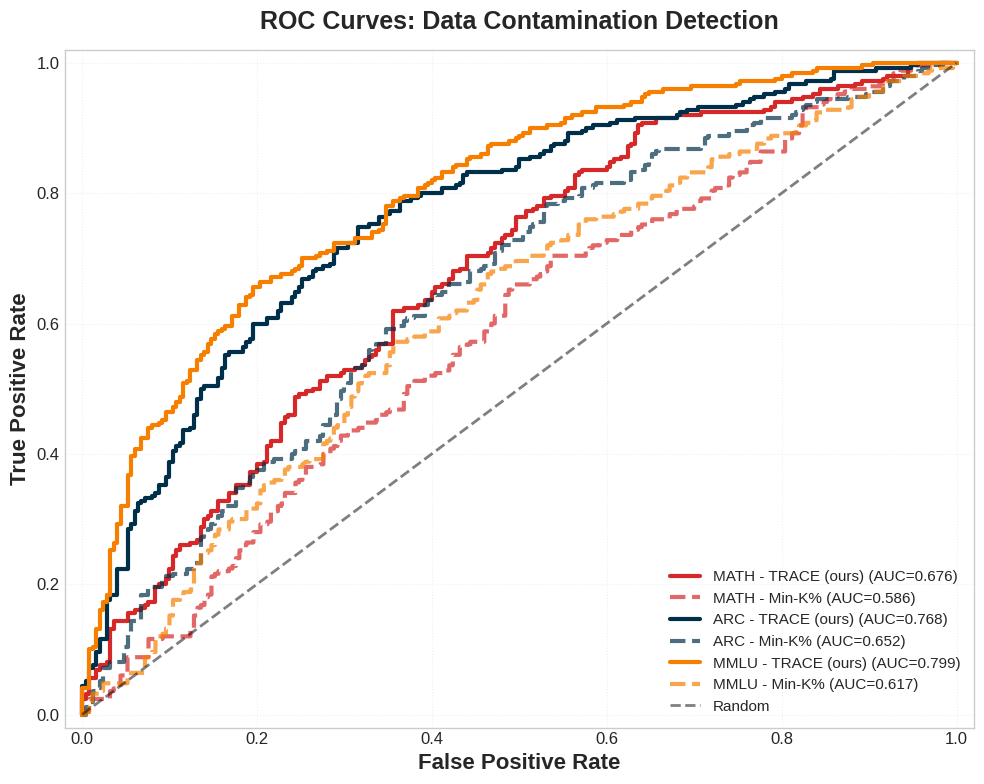

In [8]:
plt.figure(figsize=(10, 8))

for dataset in DATASETS:
    # TRACE
    if dataset in trace_results:
        tr = trace_results[dataset]
        plt.plot(tr['fpr'], tr['tpr'], 
                linestyle='-', linewidth=3, 
                color=DATASET_COLORS[dataset],
                label=f'{dataset.upper()} - TRACE (ours) (AUC={tr["auc"]:.3f})')
    
    # Min-K%
    if dataset in min_k_results:
        mink = min_k_results[dataset]
        plt.plot(mink['fpr'], mink['tpr'], 
                linestyle='--', linewidth=3, 
                color=DATASET_COLORS[dataset],
                alpha=0.7,
                label=f'{dataset.upper()} - Min-K% (AUC={mink["auc"]:.3f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random')

plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.title('ROC Curves: Data Contamination Detection', fontsize=18, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='lower right', framealpha=0.95)
plt.grid(True, alpha=0.3, linestyle=':')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.tight_layout()

save_path = OUTPUT_DIR / "roc_comparison_combined.pdf"
plt.savefig(save_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.show()

## 7. Performance Metrics Comparison

In [9]:
# Build comparison table
comparison_data = []

for dataset in DATASETS:
    row = {'Dataset': dataset.upper()}
    
    if dataset in trace_results:
        row['TRACE AUC'] = trace_results[dataset]['auc']
        row['TRACE Acc'] = trace_results[dataset]['accuracy']
    else:
        row['TRACE AUC'] = None
        row['TRACE Acc'] = None
    
    if dataset in min_k_results:
        row['Min-K% AUC'] = min_k_results[dataset]['auc']
        row['Min-K% Acc'] = min_k_results[dataset]['accuracy']
    else:
        row['Min-K% AUC'] = None
        row['Min-K% Acc'] = None
    
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))


PERFORMANCE COMPARISON
Dataset  TRACE AUC  TRACE Acc  Min-K% AUC  Min-K% Acc
   MATH   0.675760      0.630    0.585792       0.576
    ARC   0.768032      0.702    0.651632       0.610
   MMLU   0.799488      0.724    0.616872       0.598


Saved: ../report_figs/performance_comparison.pdf


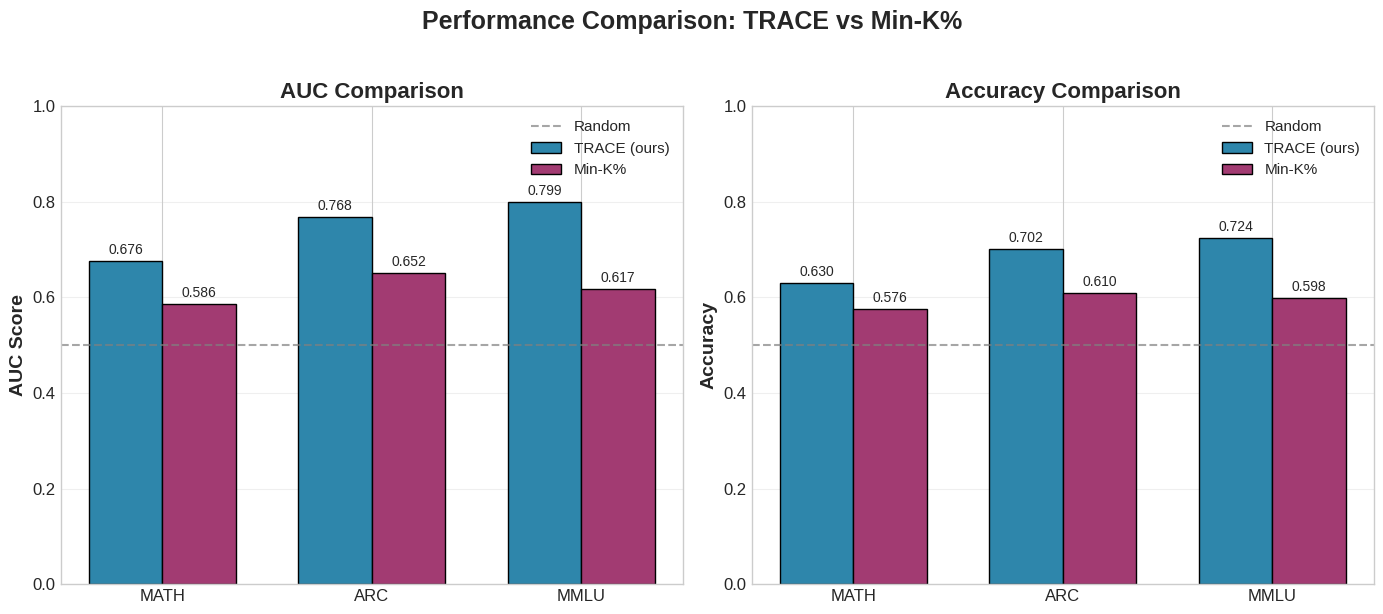

In [10]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(len(DATASETS))
width = 0.35

# AUC comparison
ax1 = axes[0]
trace_aucs = [trace_results.get(d, {}).get('auc', 0) for d in DATASETS]
mink_aucs = [min_k_results.get(d, {}).get('auc', 0) for d in DATASETS]

bars1 = ax1.bar(x - width/2, trace_aucs, width, label='TRACE (ours)', color='#2E86AB', edgecolor='black')
bars2 = ax1.bar(x + width/2, mink_aucs, width, label='Min-K%', color='#A23B72', edgecolor='black')

ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')
ax1.set_ylabel('AUC Score', fontsize=14, fontweight='bold')
ax1.set_title('AUC Comparison', fontsize=16, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([d.upper() for d in DATASETS])
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Accuracy comparison
ax2 = axes[1]
trace_accs = [trace_results.get(d, {}).get('accuracy', 0) for d in DATASETS]
mink_accs = [min_k_results.get(d, {}).get('accuracy', 0) for d in DATASETS]

bars3 = ax2.bar(x - width/2, trace_accs, width, label='TRACE (ours)', color='#2E86AB', edgecolor='black')
bars4 = ax2.bar(x + width/2, mink_accs, width, label='Min-K%', color='#A23B72', edgecolor='black')

ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')
ax2.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=16, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([d.upper() for d in DATASETS])
ax2.legend(fontsize=11)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars4:
    height = bar.get_height()
    ax2.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.suptitle('Performance Comparison: TRACE vs Min-K%', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()

save_path = OUTPUT_DIR / "performance_comparison.pdf"
plt.savefig(save_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.show()

## 8. Feature Importance Analysis (Logistic Regression)

FEATURE IMPORTANCE ANALYSIS

MATH - Top 10 Features:
  1. L2Dist_Step5: -0.6622
  2. L2Dist_Step1: +0.6259
  3. Angle_Step4: +0.5256
  4. Angle_Step1: -0.4200
  5. Angle_Step2: +0.4148
  6. GradNorm_Step1: -0.4069
  7. Loss_Step2: -0.3917
  8. L2Dist_Step3: -0.3784
  9. Loss_Step4: +0.3778
  10. L2Dist_Step4: -0.3621

ARC - Top 10 Features:
  1. Loss_Step2: -0.9990
  2. GradNorm_Step1: -0.8107
  3. GradNorm_Step2: +0.7745
  4. Loss_Step1: +0.5482
  5. L2Dist_Step1: +0.3754
  6. L2Dist_Step3: +0.3656
  7. L2Dist_Step4: -0.3126
  8. GradNorm_Step3: +0.2939
  9. Angle_Step1: -0.2613
  10. Loss_Step3: -0.2006

MMLU - Top 10 Features:
  1. Loss_Step2: -1.3638
  2. GradNorm_Step1: -0.9906
  3. L2Dist_Step1: +0.9524
  4. Angle_Step1: -0.9286
  5. Loss_Step1: +0.8760
  6. GradNorm_Step2: +0.7101
  7. L2Dist_Step3: -0.4459
  8. L2Dist_Step2: +0.4374
  9. Loss_Step5: +0.2967
  10. L2Dist_Step5: +0.2521

Saved: ../report_figs/feature_importance.pdf


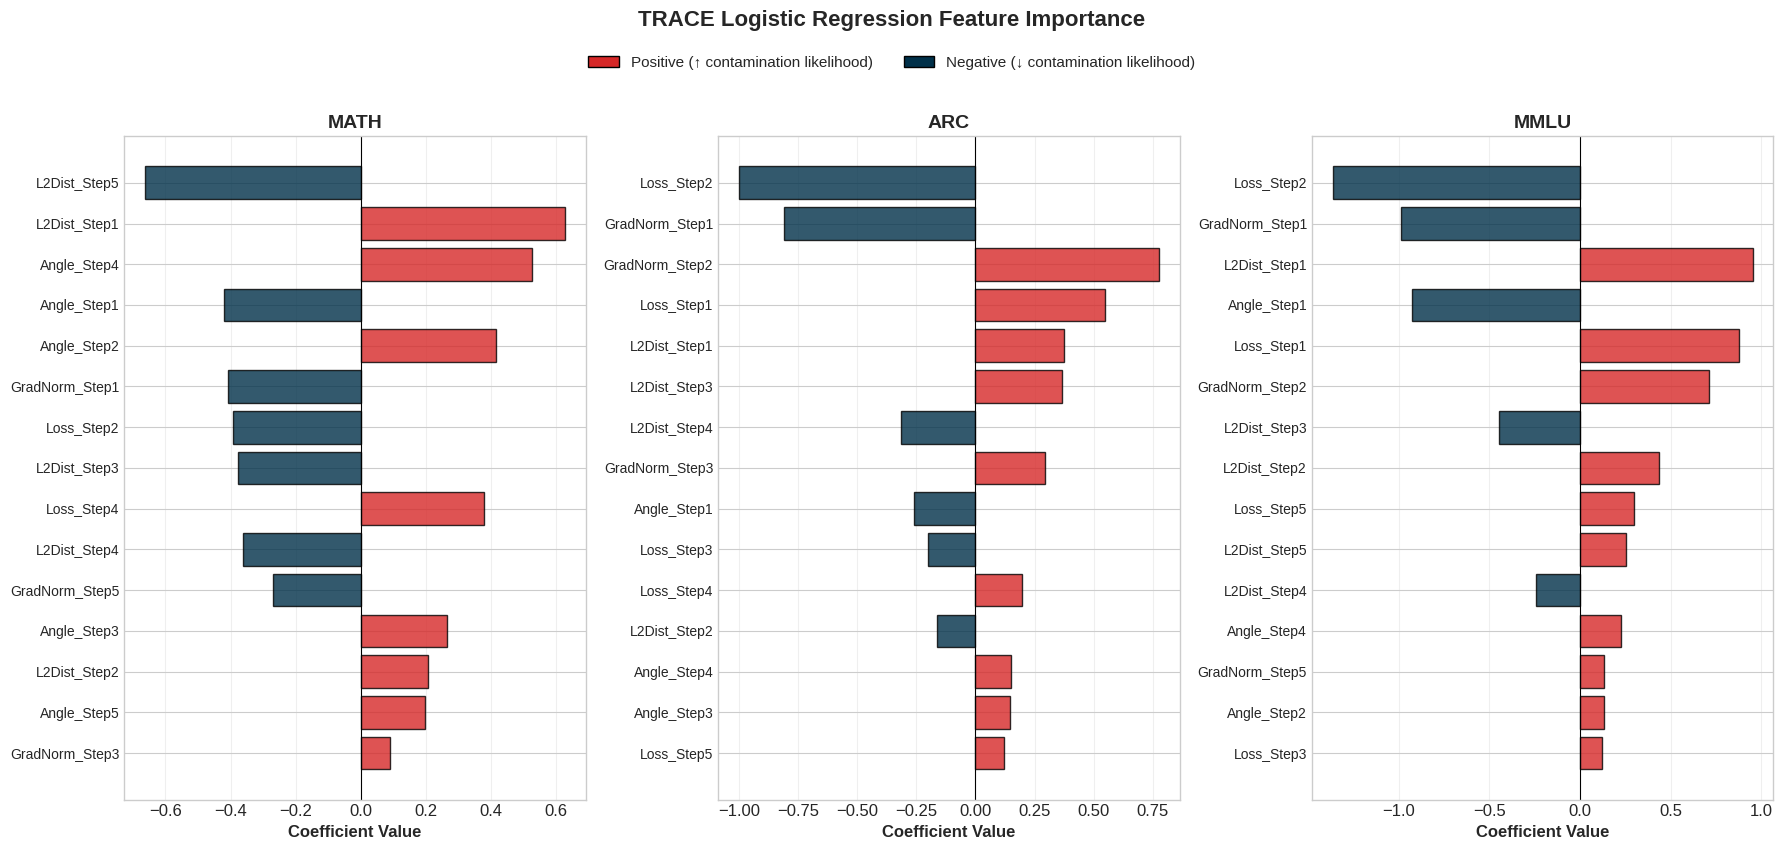

In [11]:
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, len(DATASETS), figsize=(6*len(DATASETS), 8))
if len(DATASETS) == 1:
    axes = [axes]

for idx, dataset in enumerate(DATASETS):
    ax = axes[idx]
    
    if dataset not in trained_classifiers:
        ax.set_title(f'{dataset.upper()} - No Data')
        continue
    
    clf = trained_classifiers[dataset]['clf']
    feature_names = trained_classifiers[dataset]['feature_names']
    
    # Get coefficients (feature importance for logistic regression)
    coefs = clf.coef_[0]
    
    # Sort by absolute value
    sorted_indices = np.argsort(np.abs(coefs))[::-1]
    top_n = min(15, len(coefs))  # Show top 15 features
    
    top_indices = sorted_indices[:top_n]
    top_coefs = coefs[top_indices]
    top_names = [feature_names[i] for i in top_indices]
    
    # Create color array based on coefficient sign
    colors = ['#D62828' if c > 0 else '#003049' for c in top_coefs]
    
    # Horizontal bar chart
    y_pos = np.arange(top_n)
    ax.barh(y_pos, top_coefs, color=colors, edgecolor='black', alpha=0.8)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_names, fontsize=10)
    ax.invert_yaxis()  # Top feature at top
    ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
    ax.set_title(f'{dataset.upper()}', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=0.8, linestyle='-')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Print feature importance summary
    print(f"\n{dataset.upper()} - Top 10 Features:")
    for i in range(min(10, top_n)):
        sign = '+' if top_coefs[i] > 0 else ''
        print(f"  {i+1}. {top_names[i]}: {sign}{top_coefs[i]:.4f}")

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#D62828', edgecolor='black', label='Positive (↑ contamination likelihood)'),
    Patch(facecolor='#003049', edgecolor='black', label='Negative (↓ contamination likelihood)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=11, 
           bbox_to_anchor=(0.5, 1.02), framealpha=0.95)

plt.suptitle('TRACE Logistic Regression Feature Importance', fontsize=16, fontweight='bold', y=1.06)
plt.tight_layout()

save_path = OUTPUT_DIR / "feature_importance.pdf"
plt.savefig(save_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"\nSaved: {save_path}")
plt.show()

## 9. Min-K% Analysis Across Different K Values

In [12]:
# Analyze how Min-K% performs across different k values
print("\n" + "="*80)
print("MIN-K% PERFORMANCE ACROSS DIFFERENT K VALUES")
print("="*80)

for dataset in DATASETS:
    if dataset in min_k_results:
        metrics = min_k_results[dataset]['metrics']
        print(f"\n{dataset.upper()}:")
        for k_name, k_metrics in metrics.items():
            print(f"  {k_name}: AUC={k_metrics['eval_auc']:.4f}, Acc={k_metrics['eval_accuracy']:.4f}")


MIN-K% PERFORMANCE ACROSS DIFFERENT K VALUES

MATH:
  min_k_10: AUC=0.5210, Acc=0.5140
  min_k_20: AUC=0.5734, Acc=0.5660
  min_k_30: AUC=0.5858, Acc=0.5760
  min_k_50: AUC=0.5964, Acc=0.5800

ARC:
  min_k_10: AUC=0.6557, Acc=0.6140
  min_k_20: AUC=0.6640, Acc=0.6120
  min_k_30: AUC=0.6516, Acc=0.6100
  min_k_50: AUC=0.6386, Acc=0.6060

MMLU:
  min_k_10: AUC=0.6229, Acc=0.5880
  min_k_20: AUC=0.6250, Acc=0.5860
  min_k_30: AUC=0.6169, Acc=0.5980
  min_k_50: AUC=0.6072, Acc=0.5640


Saved: ../report_figs/mink_k_analysis.pdf


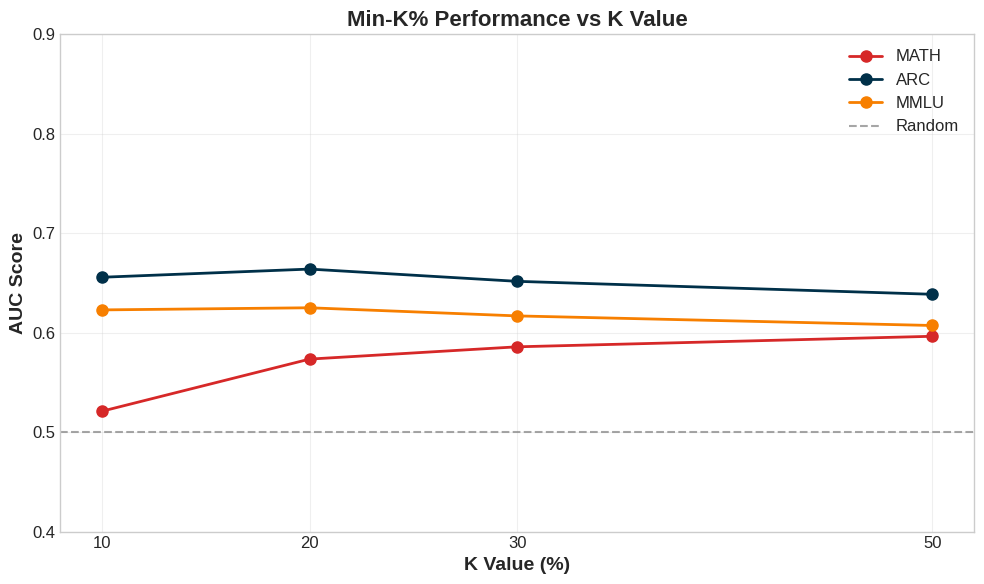

In [13]:
# Plot AUC across k values for each dataset
fig, ax = plt.subplots(figsize=(10, 6))

k_values = [10, 20, 30, 50]

for dataset in DATASETS:
    if dataset in min_k_results:
        metrics = min_k_results[dataset]['metrics']
        aucs = [metrics.get(f'min_k_{k}', {}).get('eval_auc', 0) for k in k_values]
        ax.plot(k_values, aucs, marker='o', linewidth=2, markersize=8,
               color=DATASET_COLORS[dataset], label=dataset.upper())

ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random')
ax.set_xlabel('K Value (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('AUC Score', fontsize=14, fontweight='bold')
ax.set_title('Min-K% Performance vs K Value', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
ax.set_xticks(k_values)
ax.set_ylim([0.4, 0.9])
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = OUTPUT_DIR / "mink_k_analysis.pdf"
plt.savefig(save_path, format='pdf', bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.show()

## 10. Summary

In [14]:
print("\n" + "="*80)
print("SUMMARY")
print("="*80)

print("\nTRACE (Our Method):")
for dataset in DATASETS:
    if dataset in trace_results:
        r = trace_results[dataset]
        print(f"  {dataset.upper()}: AUC={r['auc']:.4f}, Accuracy={r['accuracy']:.4f}")

print("\nMin-K% (Baseline):")
for dataset in DATASETS:
    if dataset in min_k_results:
        r = min_k_results[dataset]
        print(f"  {dataset.upper()}: AUC={r['auc']:.4f}, Accuracy={r['accuracy']:.4f}")

print("\n" + "="*80)
print(f"All figures saved to: {OUTPUT_DIR.absolute()}")
print("="*80)


SUMMARY

TRACE (Our Method):
  MATH: AUC=0.6758, Accuracy=0.6300
  ARC: AUC=0.7680, Accuracy=0.7020
  MMLU: AUC=0.7995, Accuracy=0.7240

Min-K% (Baseline):
  MATH: AUC=0.5858, Accuracy=0.5760
  ARC: AUC=0.6516, Accuracy=0.6100
  MMLU: AUC=0.6169, Accuracy=0.5980

All figures saved to: /afs/cs.wisc.edu/u/p/a/papageorgiou/re-bench-data-contamination/notebooks/../report_figs
